In [1]:
import os
import pandas as pd

## 1. Data import

In [79]:
df_MB_full = pd.read_csv('./IntermediateProducts/Result_ALL.csv') # just in case. Maybe too heavy with little benefit

df_MB_select_org = pd.read_csv('./IntermediateProducts/Result_Selected_Organisms.csv') # main target of the NLS search


df_NLSdb = pd.read_csv('./SourceData/NLSdb/signals.csv') # contains list of NLS from NLSdb

In [80]:
# df_MB_full.head()
# df_MB_select_org.head()
df_NLSdb.head()

,ID,Sequence,SignalType,AnnotationType,ConfidenceNuc,ConfidenceFam,Origin,Added,Modified
0,1,AAKKPR,NLS,Potential,2,2,In Silico Mutagenesis,2017-10-11 15:10:55,2017-10-11 15:10:55
1,2,AAKKQK,NLS,Potential,3,3,In Silico Mutagenesis,2017-10-11 15:10:55,2017-10-11 15:10:55
2,3,AAKKTK,NLS,Potential,2,2,In Silico Mutagenesis,2017-10-11 15:10:55,2017-10-11 15:10:55
3,4,AAKRRL,NLS,Potential,3,3,In Silico Mutagenesis,2017-10-11 15:10:55,2017-10-11 15:10:55
4,5,AEKKAK,NLS,Potential,5,3,In Silico Mutagenesis,2017-10-11 15:10:55,2017-10-11 15:10:55


### Make a dictionauniqueith NLS seq and its origin so the analysis below can be faster

In [82]:
df_NLS = df_NLSdb[df_NLSdb['SignalType'] == 'NLS'] # exclude NES
dict_NLS = dict(zip(df_NLS['Sequence'], df_NLS['Origin']))

In [83]:
print(len(dict_NLS))

2253


## 2. Search for proteins with putative NLSs

### A funciton to find NLS(s) in a given protein sequence

In [84]:
def searchNLS(protein_seq):
    NLS_type = dict() # for storing hit NLS and its origin
    
    for NLS, NLS_origin in dict_NLS.items():
               
        # search for NLS in a protein seq
        position = protein_seq.find(NLS)
        
        # if the NLS found, append NLS position and type to a dictionary
        if position != -1:
            NLS_type[NLS] = NLS_origin
        
    return  NLS_type

### Application of searchNLS to protein sequence in MemBrain result

In [85]:
df_MB_select_org['NLS found'] = df_MB_select_org['AA_sequence'].apply(searchNLS)

In [86]:
df_MB_select_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3240 entries, 0 to 3239
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Uniprot_ID    3240 non-null   object
 1   Organism      3240 non-null   object
 2   Protein_name  3240 non-null   object
 3   AH_or_Not     3240 non-null   object
 4   AA_sequence   3240 non-null   object
 5   Prediction    3240 non-null   object
 6   NLS found     3240 non-null   object
dtypes: object(7)
memory usage: 177.3+ KB


### Sort proteins with NLS found

In [124]:
df_MB_select_org_NLS_positive = df_MB_select_org[df_MB_select_org['NLS found'] != {}]

In [125]:
df_MB_select_org_NLS_positive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202 entries, 32 to 3209
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Uniprot_ID    202 non-null    object
 1   Organism      202 non-null    object
 2   Protein_name  202 non-null    object
 3   AH_or_Not     202 non-null    object
 4   AA_sequence   202 non-null    object
 5   Prediction    202 non-null    object
 6   NLS found     202 non-null    object
dtypes: object(7)
memory usage: 12.6+ KB


## 3. Understand how many NLS found in each organism

In [89]:
size_NLS = df_MB_select_org_NLS_positive.groupby('Organism').size()
size_whole = df_MB_select_org.groupby('Organism').size()

In [90]:
df_ratio = pd.DataFrame({'NLS': pd.Series(size_NLS), 'Whole': pd.Series(size_whole)})

### As shown below, the NLS protein frequency is in 2-10%

In [94]:
df_ratio['Ratio'] = df_ratio['NLS'] / df_ratio['Whole']
df_ratio = df_ratio.sort_values(by='Ratio', ascending=False)

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'NLS ratio (organisms with >10 proteins)')

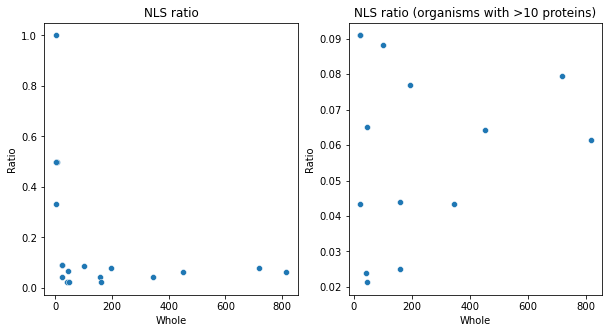

In [108]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
scatter = sns.scatterplot(data=df_ratio, x=df_ratio['Whole'], y=df_ratio['Ratio'])
plt.title('NLS ratio')

plt.subplot(122)
scatter = sns.scatterplot(data=df_ratio[df_ratio['Whole'] > 10], x=df_ratio[df_ratio['Whole'] > 10]['Whole'], y=df_ratio[df_ratio['Whole'] > 10]['Ratio'])
plt.title('NLS ratio (organisms with >10 proteins)')

## 4. Label the NLS in each protein whether in silico mutagenesis only or not

In [121]:
def judge_insilico(dict_NLS):
    NLS_evidence = 0
    for v in dict_NLS.values():
        if v != 'In Silico Mutagenesis':
            NLS_evidence = 1
            break

    return NLS_evidence

In [126]:
df_MB_select_org_NLS_positive['NLS_data_evidence'] = df_MB_select_org_NLS_positive['NLS found'].apply(judge_insilico)

<ipython-input-126-75d5125513e1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MB_select_org_NLS_positive['NLS_data_evidence'] = df_MB_select_org_NLS_positive['NLS found'].apply(judge_insilico)


In [130]:
# df_MB_select_org_NLS_positive[df_MB_select_org_NLS_positive.NLS_data_evidence == 1]

## 5. Export

In [129]:
df_MB_select_org_NLS_positive.to_csv('./FinalOutput/MemBrain_select_organism_NLSdb_found.csv', index=False)